In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/'
output_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/Models/model_outputs/'

In [ ]:
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)
    print(f"Created directory: {output_path}")
else:
    print(f"Directory already exists: {output_path}")

Directory already exists: /content/drive/MyDrive/SU Works/CPSC_5310_Project/Models/model_outputs/


In [ ]:
train_df = pd.read_parquet(data_path + 'deepdispatch_training.parquet')
test_df = pd.read_parquet(data_path + 'deepdispatch_testing.parquet')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(233850, 44)
(39445, 44)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233850 entries, 0 to 233849
Data columns (total 44 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   pickup_cluster                      233850 non-null  int64         
 1   timestamp                           233850 non-null  datetime64[ns]
 2   demand_count                        233850 non-null  float64       
 3   total_engaged_minutes               233850 non-null  float64       
 4   speed_mph                           233850 non-null  float64       
 5   airport_trip_count                  233850 non-null  float64       
 6   profit_index                        233850 non-null  float64       
 7   revenue_class                       233850 non-null  int64         
 8   day_of_week                         233850 non-null  int32         
 9   hour                                233850 non-null  int32         
 10  hour_sin

In [ ]:
target_col = 'revenue_class'

In [ ]:
cols_to_exclude = [
    'revenue_class',        # Target variable
    'timestamp',            # Time related information are already included in other features
    'hour',                 # Encoded already
    'day_of_week'           # Encoded already
]

In [ ]:
X_train = train_df.drop(columns=cols_to_exclude)
y_train = train_df[target_col]

X_test = test_df.drop(columns=cols_to_exclude)
y_test = test_df[target_col]

print(f"Final Feature Count: {X_train.shape[1]}")

Final Feature Count: 40


In [ ]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['pickup_cluster']

# Remove the categorical feature from the numeric list
if 'pickup_cluster' in numeric_features:
    numeric_features.remove('pickup_cluster')

# Pipeline

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

print("Preprocessor created.")

Preprocessor created.


In [ ]:
# Chain the preprocessor and the logistic regression model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    ))
])

full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['demand_count',
                                                   'total_engaged_minutes',
                                                   'speed_mph',
                                                   'airport_trip_count',
                                                   'profit_index', 'hour_sin',
                                                   'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos',
                                                   'is_weekend', 'is_blizzard',
                                                   'demand_count_lag_1',
                                                   'demand_count_lag_2',
                                                   'demand_count_lag_24',
                                                   '...
                                                   'airport_trip_count_lag_1',
                                                   'airport_trip_count_lag_2',
                                                   'airport_trip_count_lag_24',
                                                   'airport_trip_count_lag_168',
                                                   'demand_count_rolling_mean_3',
                                                   'demand_count_rolling_mean_8',
                                                   'demand_count_rolling_mean_24', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pickup_cluster'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

In [ ]:
# Define the parameter grid for Randomized Search
param_distributions = {
    'classifier__C': loguniform(0.01, 10)
}
tscv = TimeSeriesSplit(n_splits=2)
# Set up the Randomized Search with Cross-Validation
# n_iter=10 means it will try 10 different combinations
# cv=3 means it will use 3-fold cross-validation for each combination
random_search_cv = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distributions,
    n_iter=3,
    cv=tscv,
    verbose=2, # Shows progress
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

print("Randomized Search CV configured.")

Randomized Search CV configured.


In [ ]:
print("Starting hyperparameter search...")
random_search_cv.fit(X_train, y_train)
print("Search complete!")

Starting hyperparameter search...
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Search complete!


Best parameters found:
{'classifier__C': np.float64(0.13292918943162169)}
----------------------------------------
Best CV Score (Accuracy): 74.39%
----------------------------------------
Test Set Evaluation Report:
Test Set Accuracy: 75.71%

              precision    recall  f1-score   support

           1       0.72      0.58      0.64      2753
           2       0.73      0.79      0.76      8705
           3       0.73      0.69      0.71      9755
           4       0.73      0.74      0.73      9462
           5       0.86      0.88      0.87      8770

    accuracy                           0.76     39445
   macro avg       0.75      0.73      0.74     39445
weighted avg       0.76      0.76      0.76     39445



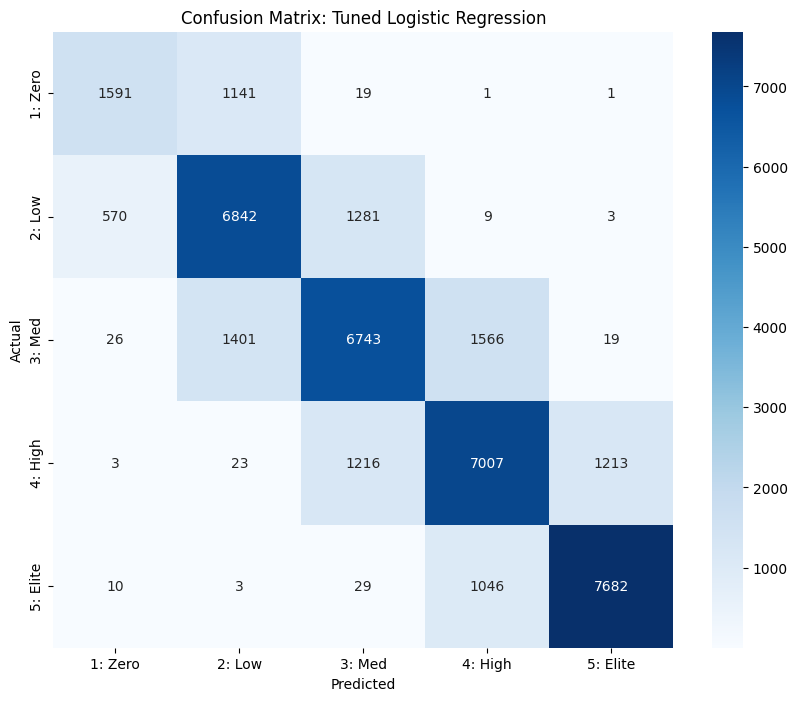

In [ ]:
# 1. Print the best parameters found
print("Best parameters found:")
print(random_search_cv.best_params_)
print("-" * 40)

# 2. Print the best cross-validation score
print(f"Best CV Score (Accuracy): {random_search_cv.best_score_:.2%}")
print("-" * 40)

# 3. Evaluate the single BEST model on the blind test data
# The search object automatically uses the best estimator it found
best_model = random_search_cv.best_estimator_
y_pred = best_model.predict(X_test)

# 4. Final Evaluation Report
print("Test Set Evaluation Report:")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print(classification_report(y_test, y_pred))

# 5. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1: Zero', '2: Low', '3: Med', '4: High', '5: Elite'],
            yticklabels=['1: Zero', '2: Low', '3: Med', '4: High', '5: Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Tuned Logistic Regression')
plt.show()